
# Adding a background to the simple peakbag

I'm going to add a background fit to the simple peakbag method. The remaining caveats are:

- I will not impose a complex prior on linewidth
- I will not apply a smoothness condition
- I will not impose a complex prior on mode heights
- I am not accounting for any asphericities due to near-surface magnetic fields

The expected effect of this will be, in order:

- Increased uncertainty on linewidths
- Risk of mode flipping on the $l = 0, 2$ pairs
- Increased runtime as the mode heights are less constrained
- Possible linewidth broadening or shifting of mode frequencies if there are significant frequency shifts

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns

import corner
import pystan
import pandas as pd
import pickle
import glob
import theano.tensor as tt
from astropy.io import ascii
import os

import pymc3 as pm
import arviz

In [2]:
target = 3632418
mal = pd.read_csv('../../data/malatium.csv', index_col=0)
idx = np.where(mal.KIC == target)[0][0]
star = mal.loc[idx]
kic = star.KIC
numax = star.numax
dnu = star.dnu

In [3]:
sfile = glob.glob('../../data/*{}*.pow'.format(kic))
data = ascii.read(sfile[0]).to_pandas()
ff, pp = data['col1'].values, data['col2'].values

In [4]:
# Read in the mode locs
cop = pd.read_csv('../../data/copper.csv',index_col=0)
cop = cop[cop.l != 3]
modelocs = cop[cop.KIC == str(kic)].Freq.values[3:39]
elocs = cop[cop.KIC == str(kic)].e_Freq.values[3:39]
modeids = cop[cop.KIC == str(kic)].l.values[3:39]

lo = modelocs.min() - .25*dnu
hi = modelocs.max() + .25*dnu

sel = (ff > lo) & (ff < hi)
f = ff[sel]
p = pp[sel]

In [5]:
def harvey(f, a, b, c):
    harvey = 0.9*a**2/b/(1.0 + (f/b)**c);
    return harvey

def get_apodization(freqs, nyquist):
    x = (np.pi * freqs) / (2 * nyquist)
    return (np.sin(x)/x)**2

def get_background(f, a, b, c, d, j, k, white, scale, nyq):
    background = np.zeros(len(f))
    background += get_apodization(f, nyq) * scale\
                    * (harvey(f, a, b, 4.) + harvey(f, c, d, 4.) + harvey(f, j, k, 2.))\
                    + white
    return background

In [6]:
try:
    backdir = glob.glob('/home/oliver/PhD/mnt/RDS/malatium/backfit/'
                        +str(kic)+'/*_fit.pkl')[0]
    with open(backdir, 'rb') as file:
        backfit = pickle.load(file)

    labels=['loga','logb','logc','logd','logj','logk','white','scale','nyq']
    res = np.array([np.median(backfit[label]) for label in labels])
    res[0:6] = 10**res[0:6]
    
    phi_ = np.array([np.median(backfit[label]) for label in labels])
    phi_sigma = pd.DataFrame(backfit)[labels].cov()
    phi_cholesky = np.linalg.cholesky(phi_sigma)
    
    model = get_background(ff, *res)
    m = get_background(f, *res)
except IndexError:
    pg = lk.periodogram.SNRPeriodogram(f*u.microhertz, pf*(cds.ppm**2/u.microhertz))
    p = pg.flatten().power.value * 2

(0, 50)

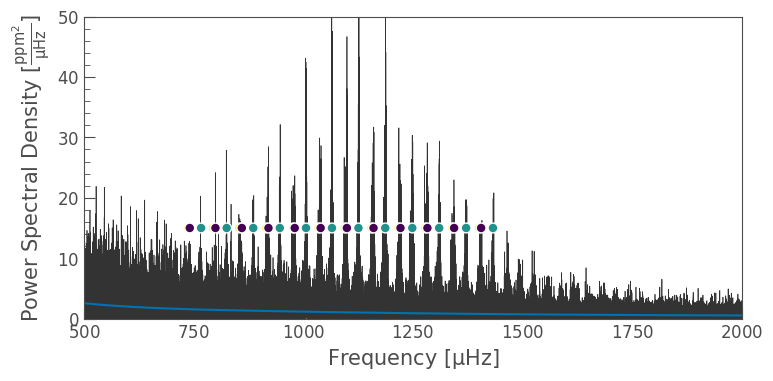

In [7]:
pg = lk.Periodogram(ff*u.microhertz, pp*(cds.ppm**2 / u.microhertz))
ax = pg.plot()
ax.plot(ff, model)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=50, edgecolor='w',zorder=100)
ax.set_xlim(500,2000)
ax.set_ylim(0, 50)

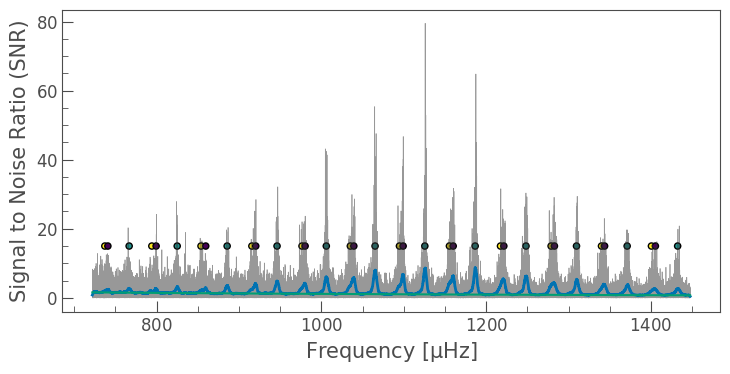

In [8]:
pg = lk.periodogram.SNRPeriodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=3.).plot(ax=ax, linewidth=2)
ax.plot(f, m)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

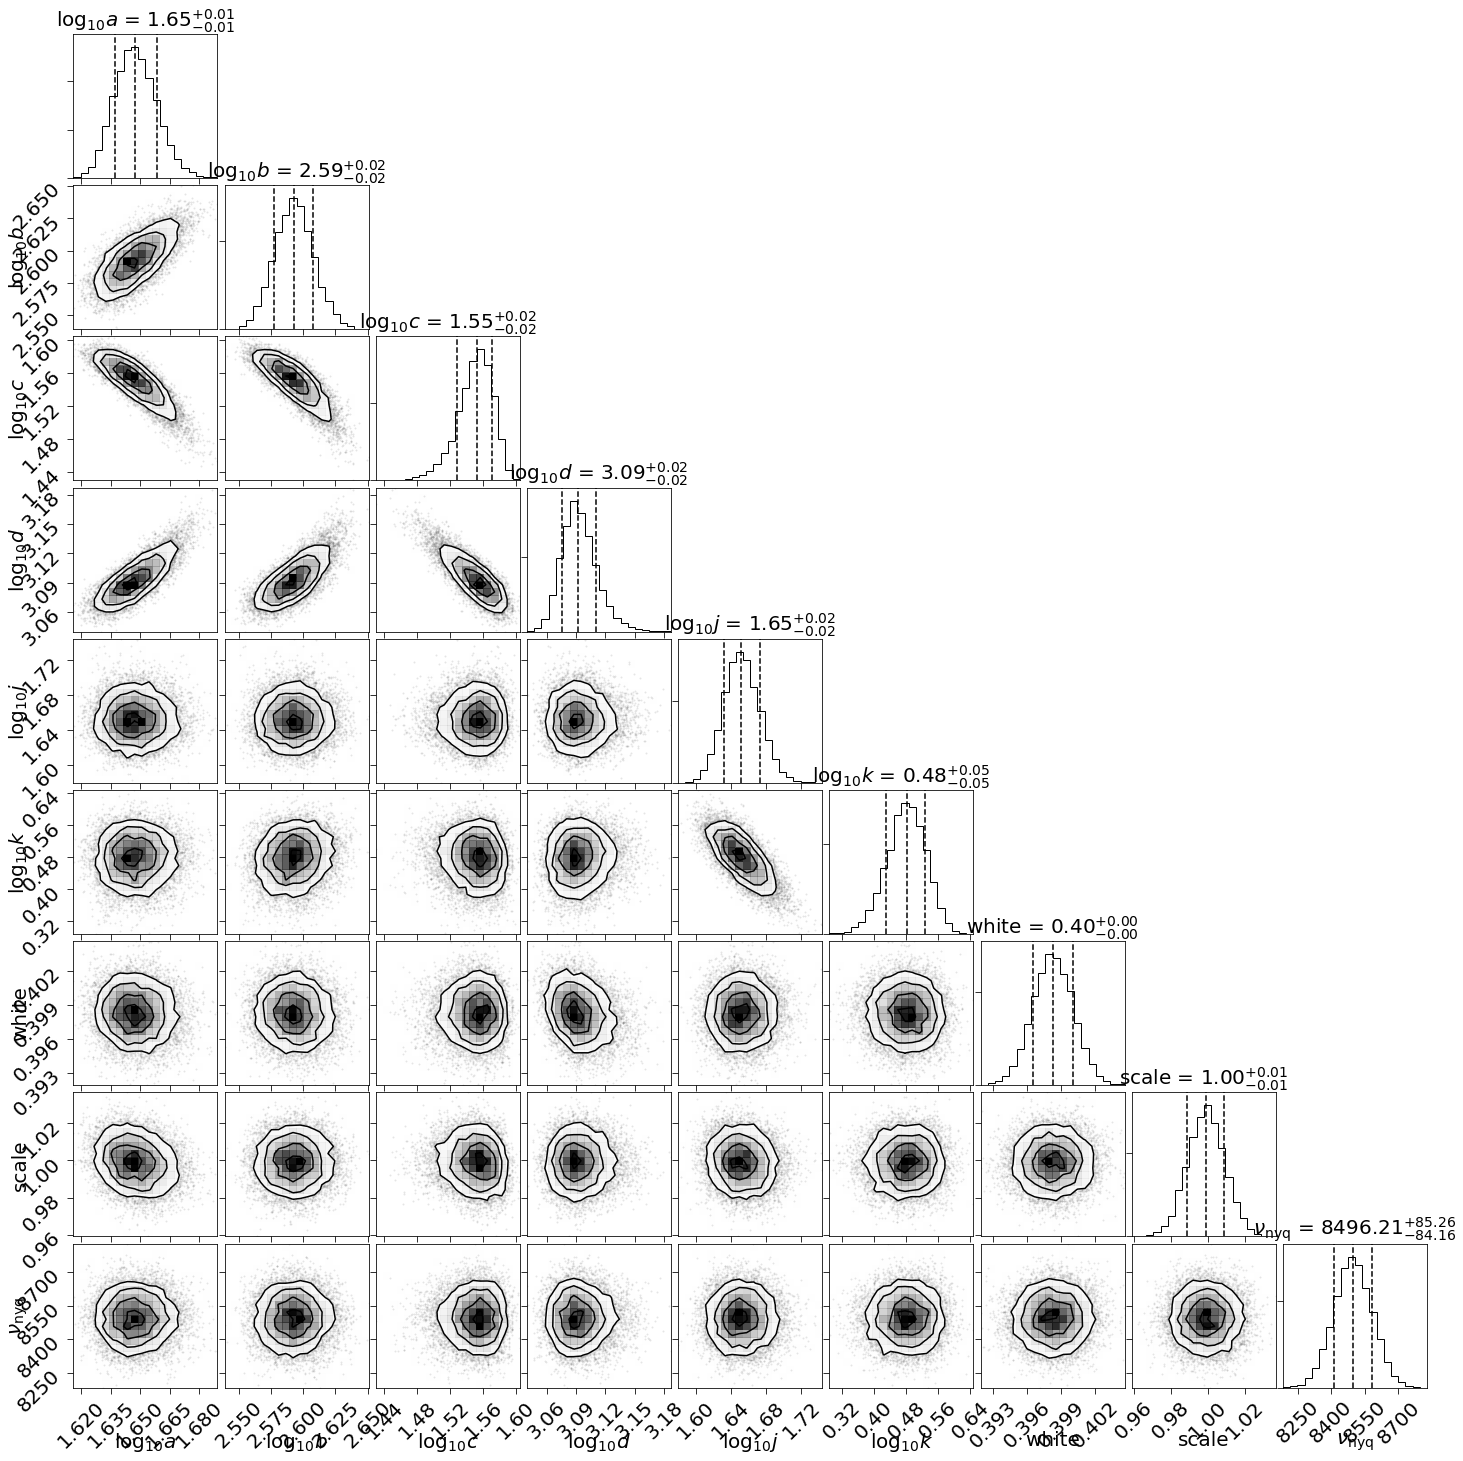

In [9]:
labels=['loga','logb','logc','logd','logj','logk',
        'white','scale','nyq']
verbose=[r'$\log_{10}a$',r'$\log_{10}b$',
        r'$\log_{10}c$',r'$\log_{10}d$',
        r'$\log_{10}j$',r'$\log_{10}k$',
        'white','scale',r'$\nu_{\rm nyq}$']

chain = np.array([backfit[label] for label in labels])

corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84],
                show_titles=True)
plt.show()

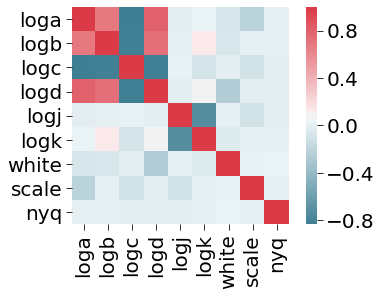

In [10]:
corr = pd.DataFrame(backfit)[labels].corr()
fig, ax = plt.subplots()
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr, cmap=cmap, square=True)

It looks like $\phi[0:6]$ are the most correlated, but I'm going to treat the whole thing with a correlation matrix to take care of those wings around the centre. If this slows stuff down too much I guess I'll just only treat the Harvey parameters.

# Build the model
Let's add the background function in...

In [11]:
class model():
    def __init__(self, f, f0_, f1_, f2_):
        self.f = f
        self.npts = len(f)
        self.M = [len(f0_), len(f1_), len(f2_)]


    def harvey(self, a, b, c):
        harvey = 0.9*a**2/b/(1.0 + (self.f/b)**c);
        return harvey

    def get_apodization(self, nyquist):
        x = (np.pi * self.f) / (2 * nyquist)
        return (np.sin(x)/x)**2

    def get_background(self, loga, logb, logc, logd, logj, logk, white, scale, nyq):
        background = np.zeros(len(self.f))
        background += self.get_apodization(nyq) * scale  \
                        * (self.harvey(10**loga, 10**logb, 4.) \
                        +  self.harvey(10**logc, 10**logd, 4.) \
                        +  self.harvey(10**logj, 10**logk, 2.))\
                        +  white
        return background        
        
    def epsilon(self, i, theano=True):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.cos(i)**2)
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sin(i)**2)
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * (3. * tt.cos(i)**2 - 1.)**2)
        eps2 = tt.set_subtensor(eps2[1], (3./8.)*tt.sin(2*i)**2)
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        if not theano:
            return eps.eval()
        return eps
        
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, i, split=0, theano=True):
        eps = self.epsilon(i, theano)
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, phi = p
        
        # Unpack background parameters
        loga = phi[0]
        logb = phi[1]
        logc = phi[2]
        logd = phi[3]
        logj = phi[4]
        logk = phi[5]
        white = phi[6]
        scale = phi[7]
        nyq = phi[8]
        
        # Calculate the modes
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, i, theano=theano)
        self.mode(1, f1, h1, g1, i, split, theano=theano)
        self.mode(2, f2, h2, g2, i, split, theano=theano)
        self.modes *= self.get_apodization(nyq)
        
        #Calculate the background
        self.back = self.get_background(loga, logb, logc, logd, logj, logk,
                                       white, scale, nyq)
        
        #Create the model
        self.mod = self.modes + self.back
        return self.mod

In [12]:
f0_ = modelocs[modeids==0]
f1_ = modelocs[modeids==1]
f2_ = modelocs[modeids==2]
f0_e = elocs[modeids==0]
f1_e = elocs[modeids==1]
f2_e = elocs[modeids==2]

Do some first guesses for height

In [13]:
def gaussian(locs, l, numax, Hmax0):
    fwhm = 0.25 * numax
    std = fwhm/2.355
    
    Vl = [1.0, 1.22, 0.71, 0.14]
    
    return Hmax0 * Vl[l] * np.exp(-0.5 * (locs - numax)**2 / std**2)   

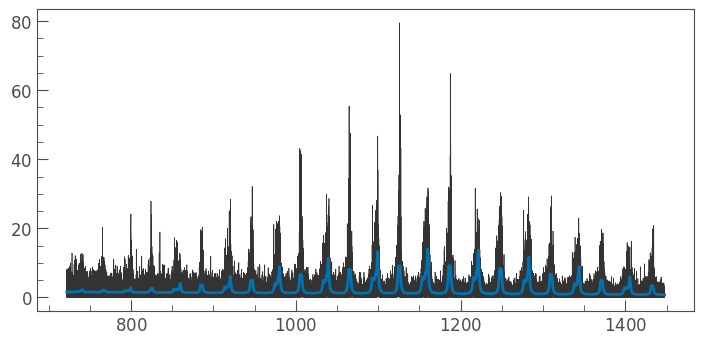

In [14]:
numax = star.numax
init =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       np.ones(len(f0_)) * 2.0,     # l0 widths
       np.ones(len(f1_)) * 2.0,     # l1 widths
       np.ones(len(f2_)) * 2.0,     # l2 widths
       np.sqrt(gaussian(f0_, 0, numax, 50.) * 2.0 * np.pi / 2.0) ,# l0 heights
       np.sqrt(gaussian(f1_, 1, numax, 50.) * 2.0 * np.pi / 2.0) ,# l1 heights
       np.sqrt(gaussian(f2_, 2, numax, 50.) * 2.0 * np.pi / 2.0) ,# l2 heights
       1.0 * np.sin(np.pi/2),       # projected splitting
       np.pi/2.,                    # inclination angle
       np.copy(phi_)]               # background parameters (in log)

mod = model(f, f0_, f1_, f2_)
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    ax.plot(f, mod.model(init, theano=False), lw=2)

# Build the priors in PyMC3

In [15]:
pm_model = pm.Model()

with pm_model:   
    # Frequencies
    f0 = pm.Normal('f0', mu=f0_, sigma=f0_e*10., testval=f0_, shape=len(f0_))
    f1 = pm.Normal('f1', mu=f1_, sigma=f1_e*10., testval=f1_, shape=len(f1_))
    f2 = pm.Normal('f2', mu=f2_, sigma=f2_e*10., testval=f2_, shape=len(f2_))
    
    # Mode linewidths
    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init[3], shape=len(init[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init[4], shape=len(init[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init[5], shape=len(init[5]))
    
    # Mode amplitudes
    a0 = pm.HalfNormal('a0', sigma=20., testval=init[6], shape=len(init[6]))
    a1 = pm.HalfNormal('a1', sigma=20., testval=init[7], shape=len(init[7]))
    a2 = pm.HalfNormal('a2', sigma=20., testval=init[8], shape=len(init[8]))
    
    # Mode heights (determined by amplitude and linewidth)
    h0 = pm.Deterministic('h0', 2*a0**2/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1**2/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2**2/np.pi/g2)
    
    # Rotation and inclination parameterizations
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init[10])
    cosi = pm.Uniform('cosi', 0., 1.)
    
    # Detangled inclination and splitting
    i = pm.Deterministic('i', np.arccos(cosi))
    split = pm.Deterministic('split', xsplit/pm.math.sin(i))
    
    # Background treatment
    phi = pm.MvNormal('phi', mu=phi_, chol=phi_cholesky, testval=phi_, shape=len(phi_))
    
    #Model
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, phi])
    
    like = pm.Gamma('like', alpha=1, beta=1.0/fit, observed=p)

In [16]:
with pm_model:
    trace = pm.sample(chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [phi, cosi, xsplit, a2, a1, a0, g2, g1, g0, f2, f1, f0]
Sampling 4 chains: 100%|██████████| 4000/4000 [8:24:54<00:00, 16.55s/draws]   
ERROR:pymc3:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


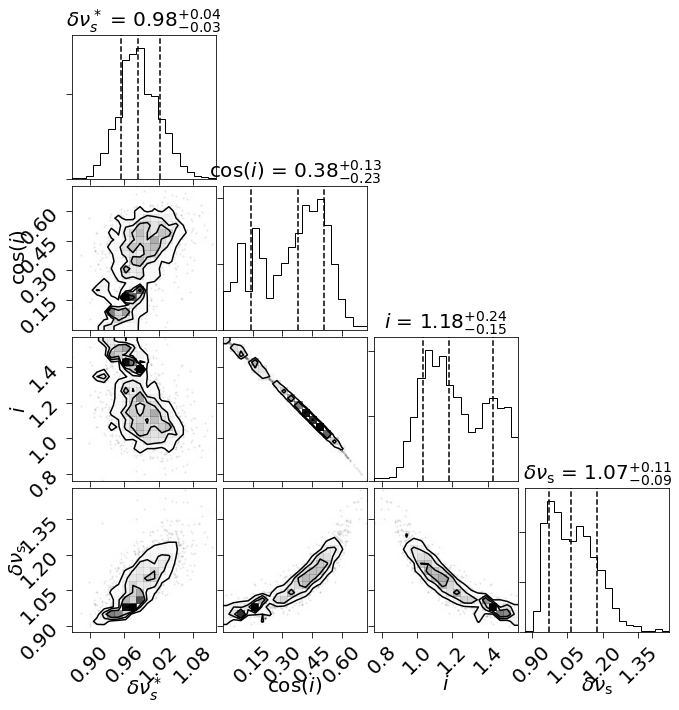

In [17]:
labels=['xsplit','cosi','i','split']
chain = np.array([trace[label] for label in labels])
verbose = [r'$\delta\nu_s^*$',r'$\cos(i)$',r'$i$',r'$\delta\nu_{\rm s}$']
corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84]
              ,show_titles=True)
plt.show()

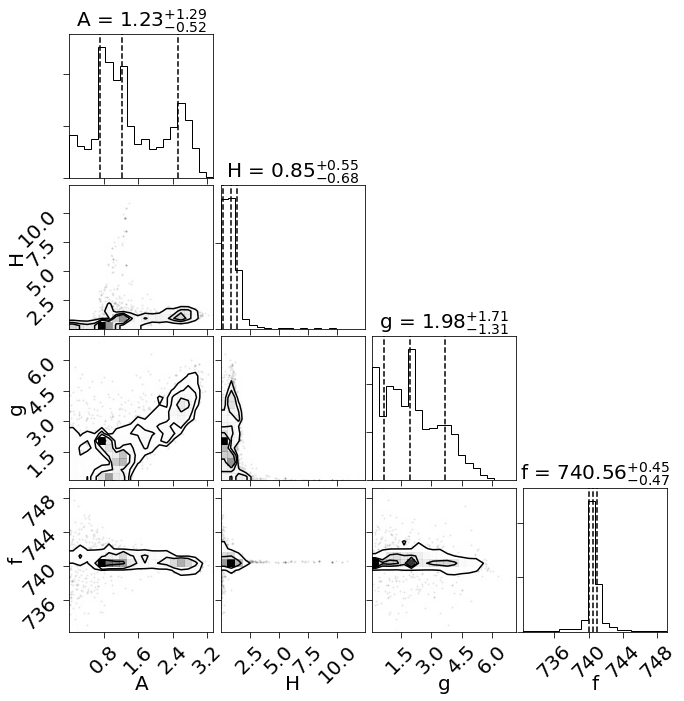

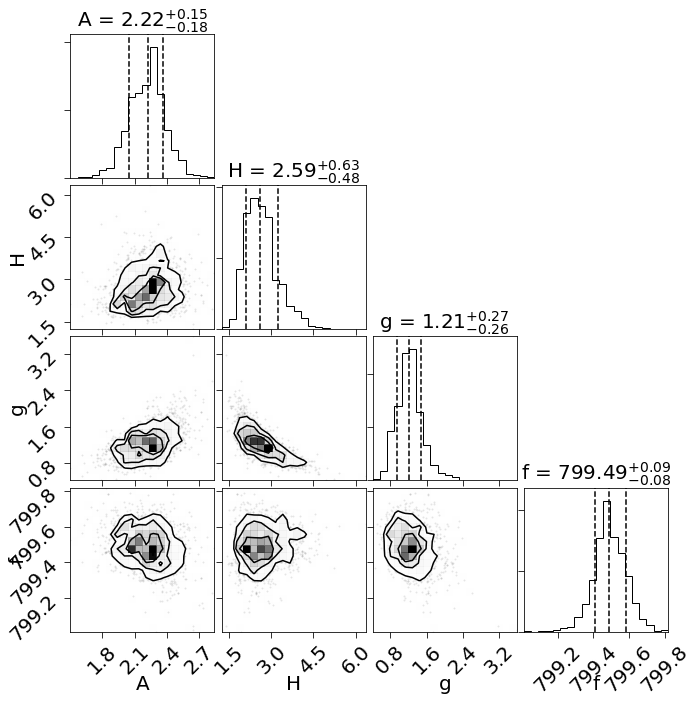

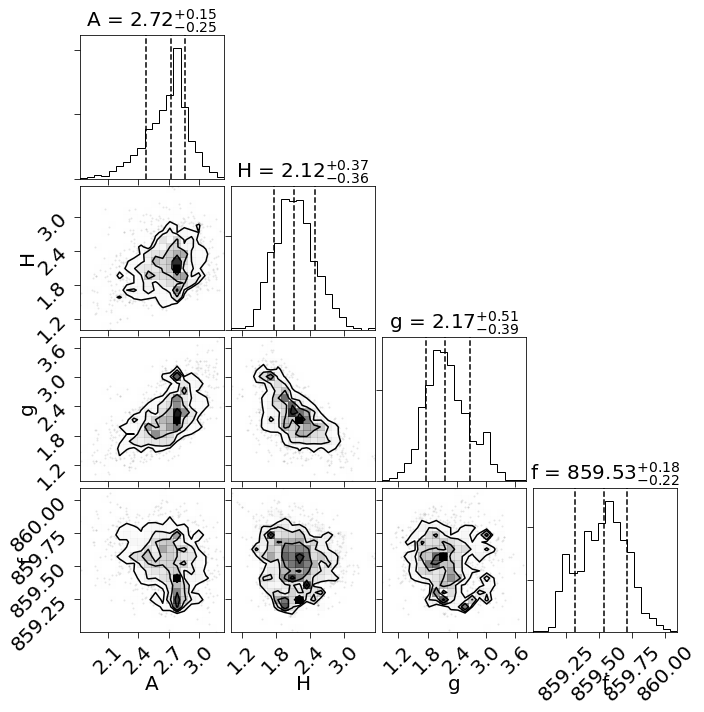

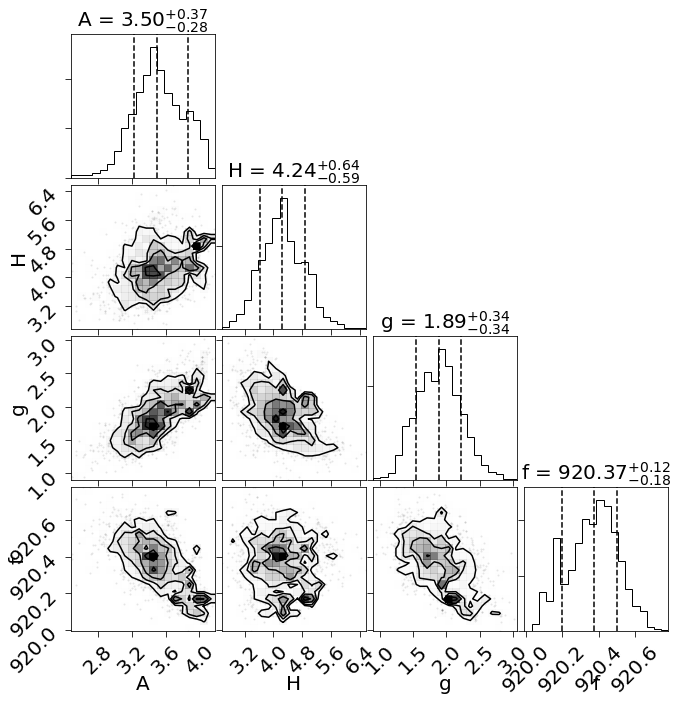

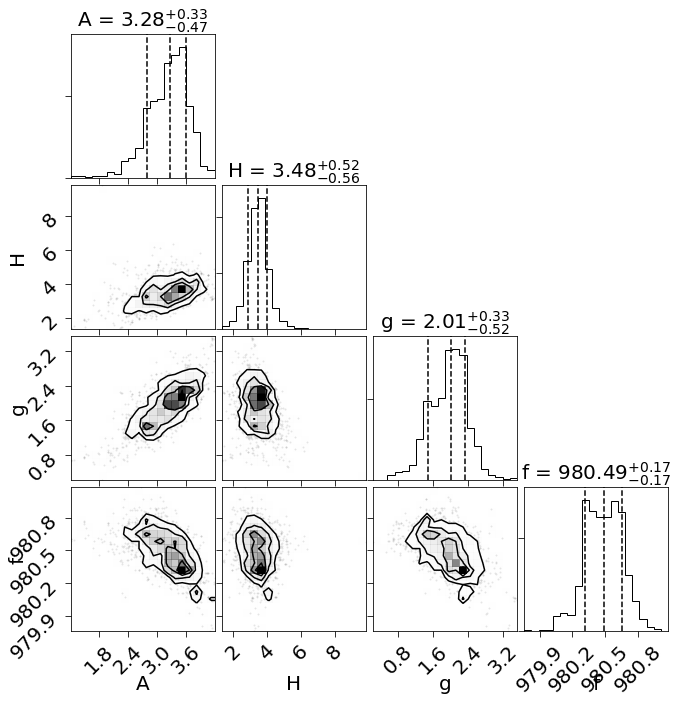

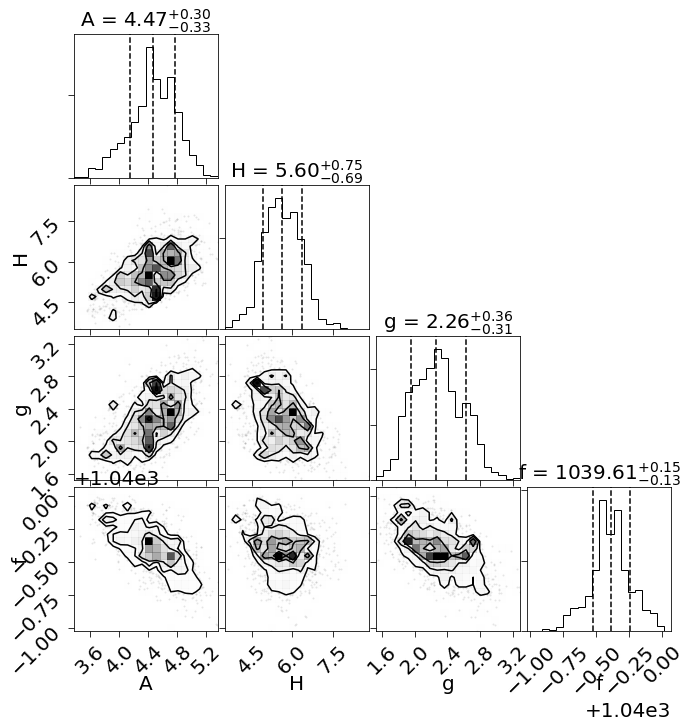

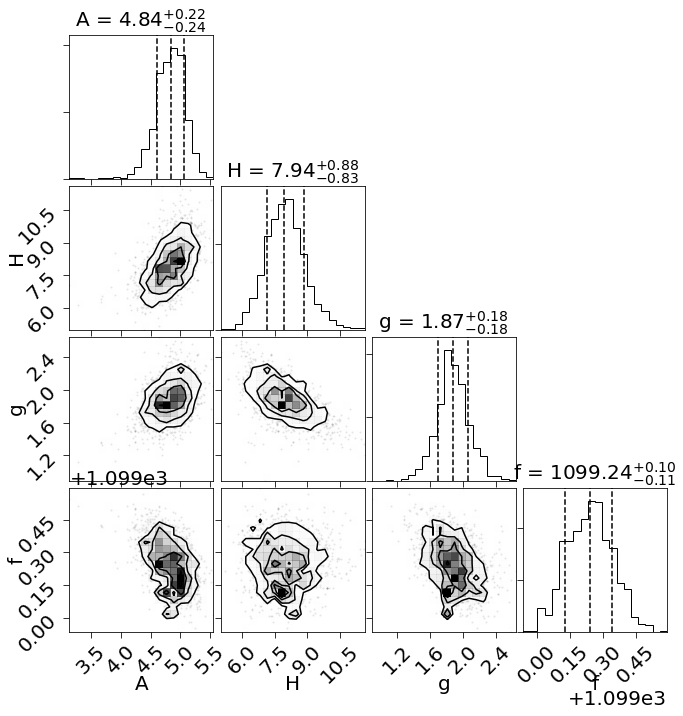

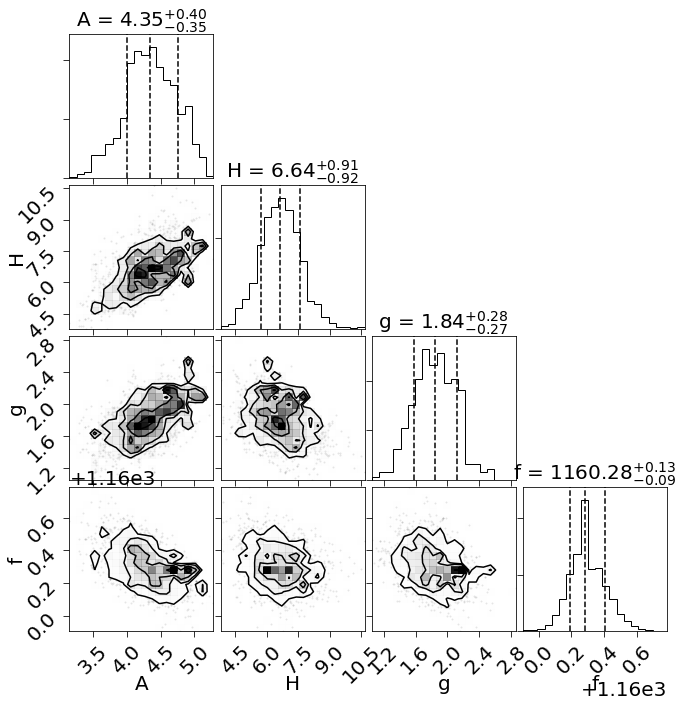

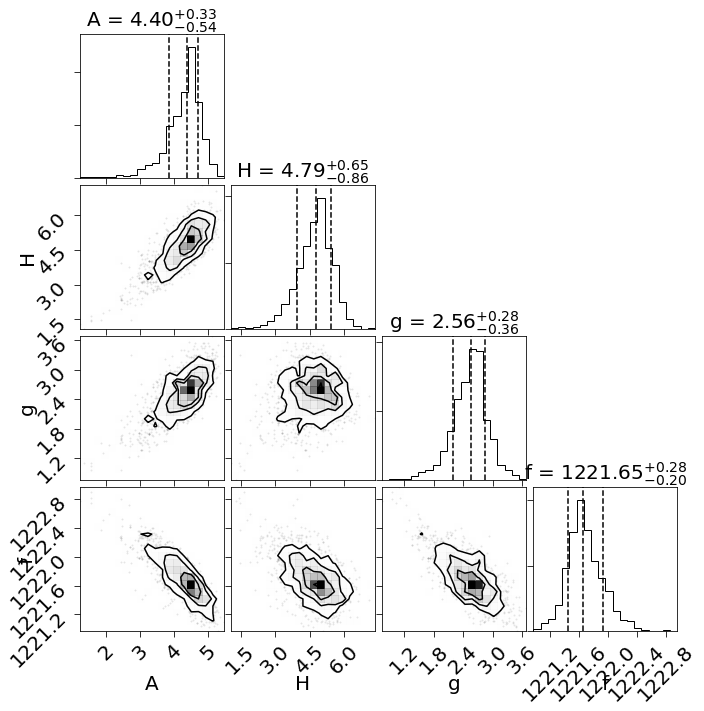

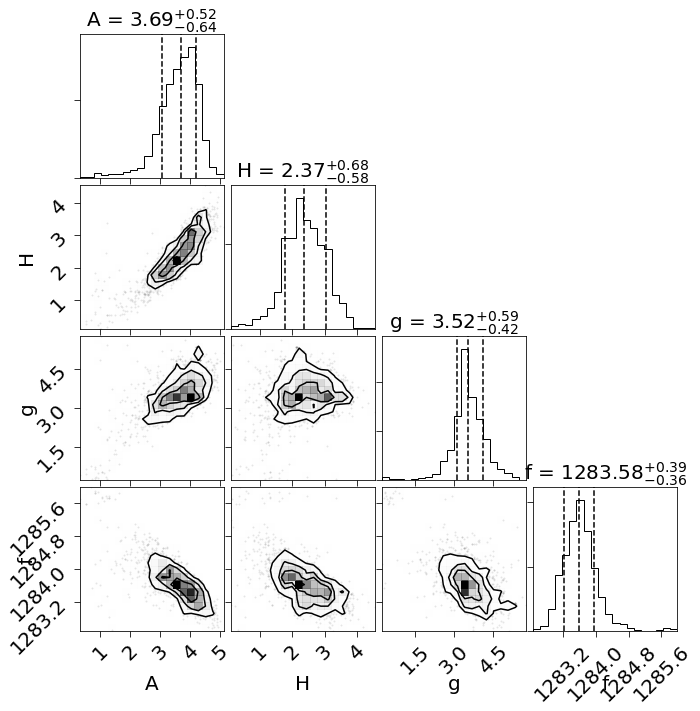

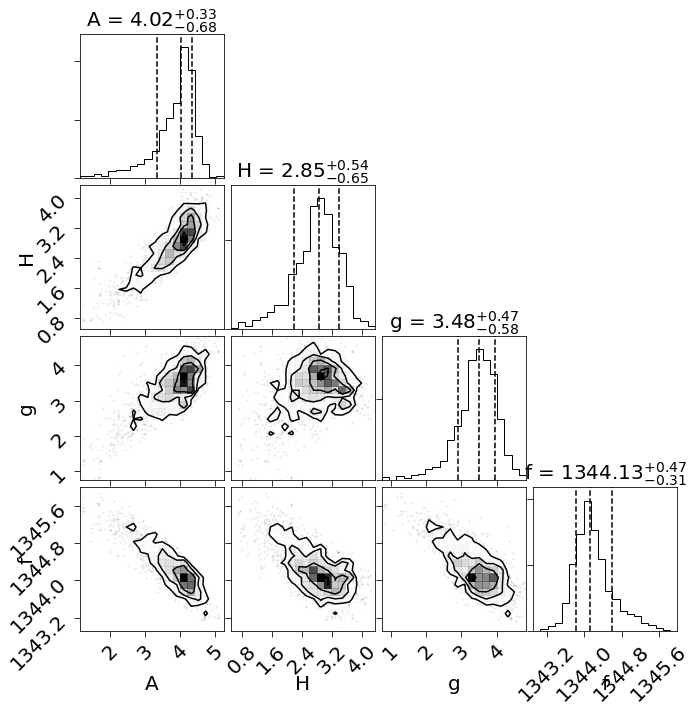

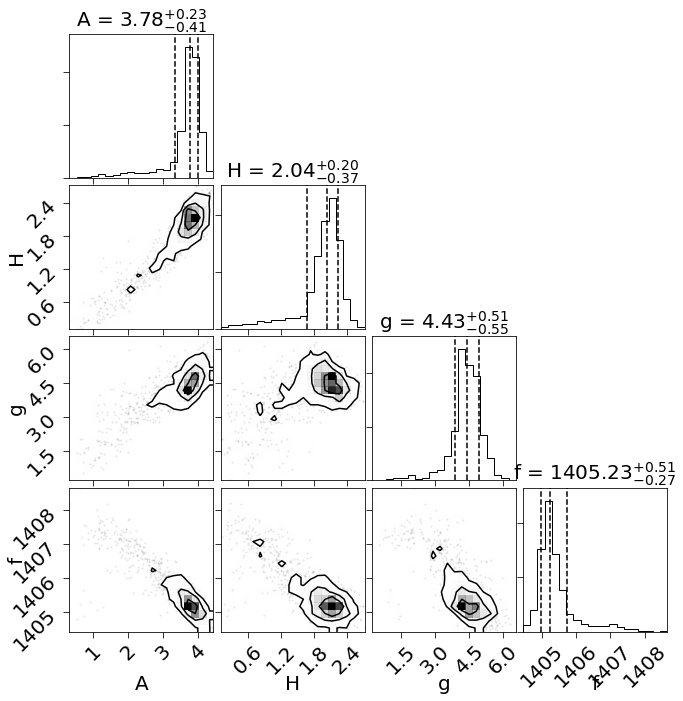

In [18]:
for idx in range(len(trace['h0'].T)):
    chain = np.array([trace['a0'].T[idx], trace['h0'].T[idx], trace['g0'].T[idx], trace['f0'].T[idx]])
    corner.corner(chain.T, labels=['A','H','g','f'],
                  quantiles=[0.16, 0.5, 0.84],show_titles=True)
    plt.show()

/home/oliver/.local/lib/python3.7/site-packages/arviz/plots/traceplot.py:156: SyntaxWarning: max_plots is smaller than the number of variables to plot generating only max_plots traceplots
  SyntaxWarning,


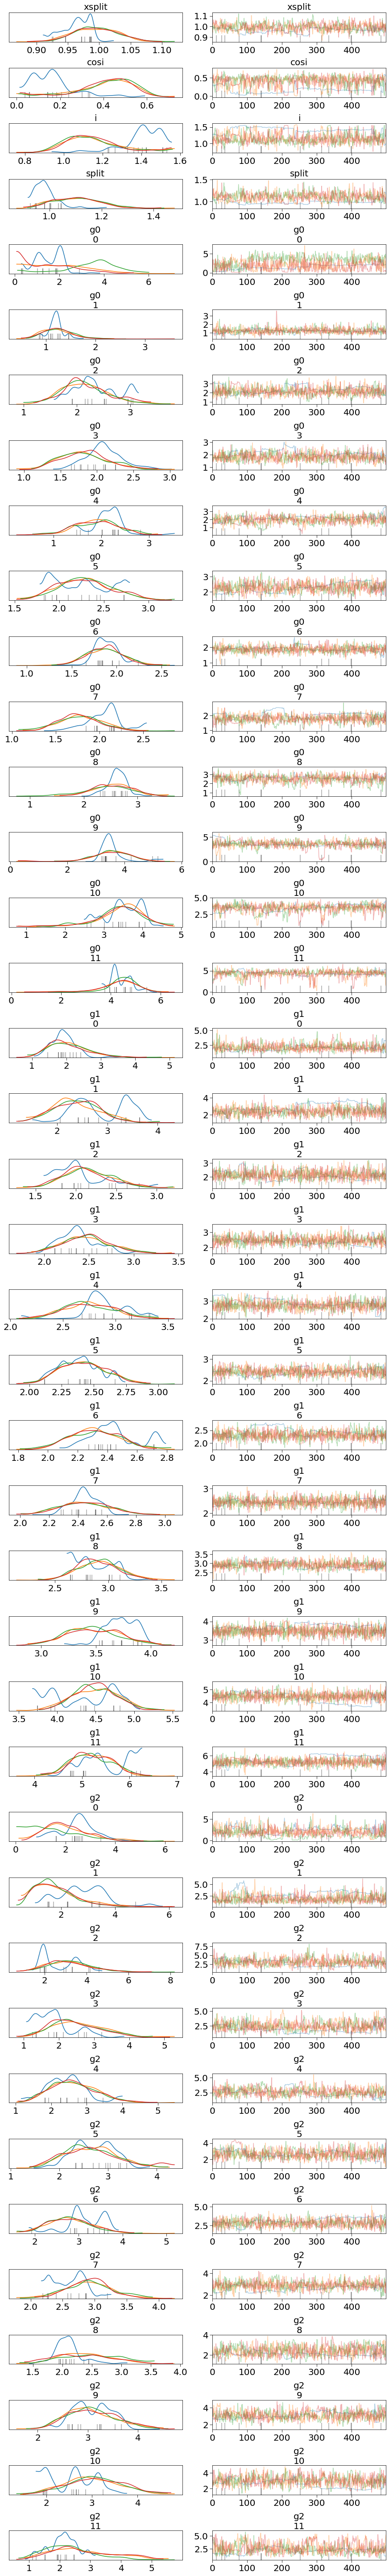

In [19]:
pm.traceplot(trace, var_names=['b','xsplit','cosi','i','split','g0','g1','g2','h0','h1','h2'])
plt.show()

In [24]:
pm.summary(trace)

mean          sd   mc_error      hpd_2.5     hpd_97.5  \
f0__0    740.555872    1.131599   0.040898   738.032176   743.252184   
f0__1    799.491389    0.093258   0.003540   799.296118   799.661496   
f0__2    859.522965    0.181583   0.012097   859.198891   859.827796   
f0__3    920.362345    0.138823   0.010057   920.074725   920.592614   
f0__4    980.482306    0.174640   0.010725   980.079221   980.769045   
f0__5   1039.606564    0.153532   0.007654  1039.299962  1039.929320   
f0__6   1099.239388    0.103466   0.006479  1099.022883  1099.417967   
f0__7   1160.300432    0.111668   0.004384  1160.080138  1160.524816   
f0__8   1221.683397    0.253105   0.012954  1221.273668  1222.302813   
f0__9   1283.623655    0.436283   0.023981  1282.857889  1284.451548   
f0__10  1344.197849    0.431559   0.023653  1343.486761  1345.203736   
f0__11  1405.400641    0.585779   0.035919  1404.508543  1406.878975   
f1__0    766.639260    0.151258   0.005252   766.316408   766.930164   
f1__1    825.064453    0.167206   0.006524   824.740917   825.388159   
f1__2    885.628762    0.140989   0.007146   885.335979   885.890919   
f1__3    946.142208    0.109173   0.005222   945.938801   946.352782   
f1__4   1005.995308    0.100676   0.004009  1005.823536  1006.223902   
f1__5   1065.116851    0.084770   0.003519  1064.957862  1065.291750   
f1__6   1125.593583    0.083817   0.004617  1125.447892  1125.772791   
f1__7   1186.718348    0.094769   0.006006  1186.556473  1186.911628   
f1__8   1248.256751    0.096963   0.005127  1248.085516  1248.441644   
f1__9   1309.841416    0.105599   0.004618  1309.646295  1310.056590   
f1__10  1371.212439    0.154008   0.010097  1370.955089  1371.545507   
f1__11  1432.548676    0.195044   0.012570  1432.159650  1432.897511   
f2__0    734.070768   10.463222   1.035625   711.620130   740.627892   
f2__1    794.288339    0.371301   0.017222   793.636893   795.128674   
f2__2    854.196586    0.614589   0.038650   853.113469   855.384312   
f2__3    915.837436    0.426667   0.030481   914.960727   916.594770   
f2__4    976.812690    0.483725   0.030375   975.929452   977.790482   
f2__5   1035.337495    0.318068   0.017778  1034.823930  1036.061670   
...             ...         ...        ...          ...          ...   
h0__10     2.782383    0.609018   0.035286     1.455698     3.867435   
h0__11     1.921407    0.433933   0.027544     0.857506     2.585035   
h1__0      2.559189    0.589758   0.022956     1.507663     3.668186   
h1__1      2.946641    0.539679   0.022697     2.054634     4.040037   
h1__2      4.223399    0.603506   0.032597     3.141524     5.343064   
h1__3      6.115395    0.622857   0.025350     4.917351     7.356649   
h1__4      7.714471    0.763222   0.039032     6.134407     9.086596   
h1__5     11.422935    0.987119   0.044926     9.558213    13.384350   
h1__6     12.086904    1.111576   0.063316    10.042525    14.106095   
h1__7     12.375115    0.957797   0.033403    10.647225    14.390379   
h1__8      8.631735    0.717966   0.040345     7.370585     9.946821   
h1__9      5.987478    0.452844   0.018820     5.260983     6.959706   
h1__10     3.814219    0.269968   0.013310     3.310497     4.308543   
h1__11     2.419411    0.206682   0.010336     2.044689     2.790525   
h2__0     49.111167  422.791970  28.752941     0.001261   127.064253   
h2__1      1.607788    0.645460   0.034315     0.626140     2.889960   
h2__2      1.533315    0.392705   0.018956     0.918551     2.232772   
h2__3      2.846444    0.656902   0.032030     1.635484     4.001974   
h2__4      3.522296    0.622534   0.032187     2.307666     4.761361   
h2__5      5.020599    0.787500   0.037764     3.608482     6.599314   
h2__6      4.340067    0.697929   0.038348     3.250521     5.701468   
h2__7      6.199107    0.707271   0.031232     4.934288     7.656254   
h2__8      5.551537    0.863601   0.042457     3.839482     7.126654   
h2__9      4.956654    0.670105   0.026109     3.733450

In [20]:
cmap = sns.color_palette('plasma', n_colors = 10)

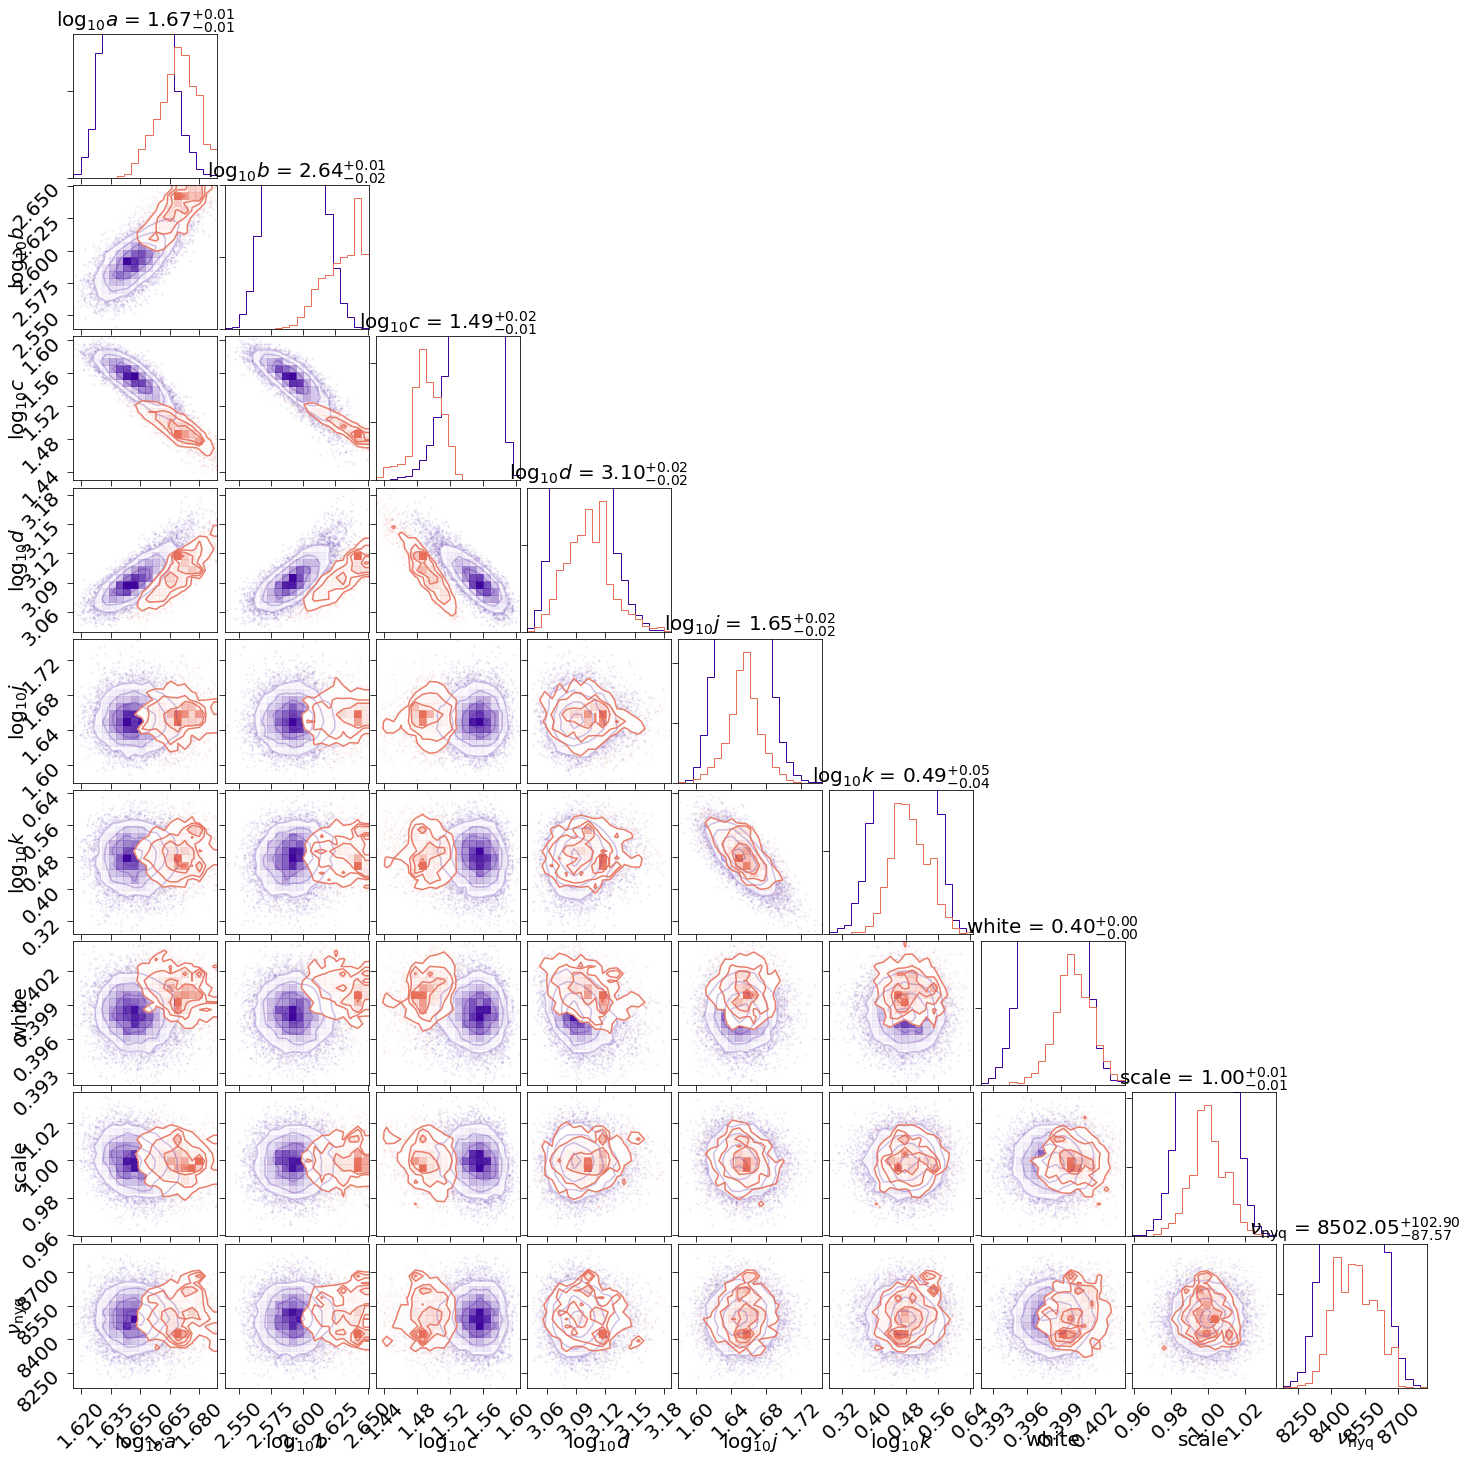

In [21]:
labels=['loga','logb','logc','logd','logj','logk',
        'white','scale','nyq']
verbose=[r'$\log_{10}a$',r'$\log_{10}b$',
        r'$\log_{10}c$',r'$\log_{10}d$',
        r'$\log_{10}j$',r'$\log_{10}k$',
        'white','scale',r'$\nu_{\rm nyq}$']

backchain = np.array([backfit[label] for label in labels]).T
phichain = np.array([trace['phi'][:,idx] for idx in range(len(phi_))]).T
limit = [(backfit[label].min(), backfit[label].max()) for label in labels]


fig = corner.corner(backchain, color=cmap[0], range=limit)
corner.corner(phichain, fig=fig, show_titles=True, labels=verbose, color=cmap[6], range=limit)

plt.show()

Looks like all the background parameters have been tightened up or remained within the priors. Always good to check!

### Now let's plot some output evaluation:

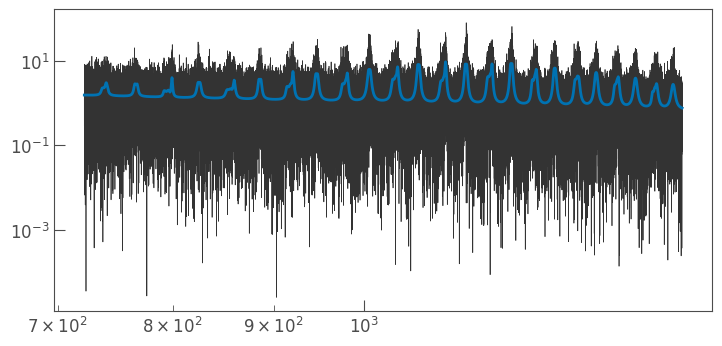

In [27]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'phi']
    res = np.array([np.median(trace[label],axis=0) for label in labels])
    ax.plot(f, mod.model(res, theano=False), lw=2)
    ax.set_yscale('log')
    ax.set_xscale('log')

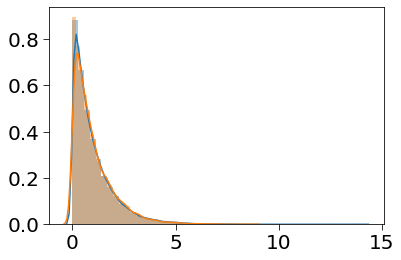

In [30]:
import seaborn as sns
sns.distplot(p/mod.model(res, theano=False))
sns.distplot(np.random.chisquare(2, size=10000)/2)

Model looks reasonable, The model fits the $\chi_2^2$ noise, we're all good!